In [108]:
# read variables iwc,zKu, iwc_label and zw_label from file cloudSat_thr01.nc
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
with nc.Dataset('cloudSat_thr01.nc','r') as f:
    iwc=f.variables['iwc'][:]
    zW=f.variables['zKu'][:]
    iwc_label=f.variables['iwc_label'][:]
    zw_label=f.variables['zw_label'][:]
    print(iwc.shape)



(138606, 50)


In [109]:
import pickle
from kazrRet import *
d=pickle.load(open('iwcCoeff.pkl','rb'))
iwcCoeff=d['iwcCoeff']
peak=d['peak']
iwcCoeff_SSRG=np.polyfit(zST[2,:],np.log10(iwcST[2,:]),1)
print(iwcCoeff_SSRG)
#print(iwcCoeff)

[ 0.08061103 -1.50649553]


In [110]:
nC=36
iwc_CSL=np.zeros((nC),float)
iwc_CSLn=np.zeros((nC),float)
iwc_SSRGL=np.zeros((nC),float)
for i in range(nC):
    a=np.nonzero(iwc_label==i)
    s1=0
    s2=0
    s3=0
    for k in a[0]:
        zw1=zW[k,:]
        a1=np.nonzero(zw1>-22)
        iwc1_SSRG=10**(iwcCoeff_SSRG[0]*zw1[a1]+iwcCoeff_SSRG[1])
        iwc1_CS=10**(iwcCoeff[i,0]*zw1[a1]+iwcCoeff[i,1])
        s1+=np.sum(iwc1_SSRG)
        s2+=np.sum(iwc[k,a1])
        s3+=np.sum(iwc1_CS)
    #print(s3/s2)
    iwc_CSL[i]=s3
    iwc_CSLn[i]=s2
    iwc_SSRGL[i]=s1


In [112]:
print(iwc_CSLn.sum()/iwc_SSRGL.sum())
#plt.hist(iwc_CSLn/iwc_CSL)
#plt.figure()
#plt.scatter(-np.log10(iwc_SSRGL/iwc_CSLn)+np.log10(1.11),peak)
print(np.corrcoef(-np.log10(iwc_SSRGL/iwc_CSLn),peak))
dnCoeff=np.polyfit(peak,-np.log10(iwc_SSRGL/iwc_CSL)+np.log10(1.11),1)
print(dnCoeff)
dnCoeff=np.array([0.01381017, 0.54397871])
dnCoeff=np.array([0.01975583, 0.22])
dn1D=np.polyval(dnCoeff,range(50))
#print(10**(dn1D))
#print(iwcCoeff_SSRG)

3.331030095567131
[[1.        0.9573302]
 [0.9573302 1.       ]]
[0.01975583 0.22229753]


In [113]:
with nc.Dataset('kext_atm.nc','r') as f:
    kext_atm=f.variables['kext_atm'][:]
    kext_atm=np.array(kext_atm)

with nc.Dataset('profiles.nc','r') as f:
    qv=f.variables['qv'][:]
    press=f.variables['press'][:]
    temp=f.variables['temp'][:]
    rho=f.variables['rho'][:]

kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]


In [124]:
import lidarSim as lidSim
fisot=2.7
umu=np.cos(np.deg2rad(53))
nt1,nz=qv.shape
height=np.arange(nz+1)*0.240
nt=zW.shape[0]
iwc_SSRG=np.zeros((nt,50),float)
wc_SSRG=np.zeros((nt,50),float)
#dn1D*=0
dmCoeff=np.polyfit(zST[2,:],np.log10(dmST[2,:]),1)
iwcLowCoeff=np.polyfit(zST[2,:200],np.log10(iwcST[2,:200]),1)
kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]
print(dmCoeff)
dn1Da=dn1D+1.75
tbL=[]
epsL=[]
zKu=np.zeros((nt,50),float)-99.9
zKuL=[]
for i in range(nt):
    zw1=zW[i,:]
    a1=np.nonzero(zw1>-22)
    kextI=np.zeros((50,4),float)
    salbI=np.zeros((50,4),float)
    asymI=np.zeros((50,4),float)
    ic=np.random.randint(0,30)
    kext1D=kext_atm[ic,:,:].copy()
    salb1D=np.zeros((64,4),float)
    asym1D=np.zeros((64,4),float)
    for k in a1[0]:
        ifind = lidSim.bisection2(zST[2,:],zw1[k]-10*(dn1Da[k]))
        iwc_SSRG[i,k]=iwcST[2,ifind]*10**(dn1Da[k])
        zKu[i,k]=zST[0,ifind]+10*(dn1Da[k])
        if ifind==1:
            iwc_SSRG[i,k]=10**(iwcLowCoeff[0]*(zw1[k]-10*dn1Da[k])+iwcLowCoeff[1]+dn1Da[k])
            for ifreq in range(4):
                kextI[k,ifreq]=10**(kextCoeffL[ifreq][0]*(zw1[k]-10*dn1Da[k])+kextCoeffL[ifreq][1]+dn1Da[k])
                salbI[k,ifreq]=kextI[k,ifreq]*kscaST[ifreq+2,0]/kextST[ifreq+2,0]  
                asymI[k,ifreq]=gST[ifreq+2,0]
            zKu[i,k]=zw1[k]
        else:
            for ifreq in range(4):
                kextI[k,ifreq]=kextST[ifreq+2,ifind]*10**(dn1Da[k])
                salbI[k,ifreq]=kscaST[ifreq+2,ifind]
                asymI[k,ifreq]=gST[ifreq+2,ifind]

    kext1D[14:64,:]+=kextI[:,:]
    salb1D[14:64,:]=salbI[:,:]
    asym1D[14:64,:]=asymI[:,:]
    salb1D/=kext1D
    emis=0.8+np.random.random()*0.2
    ebar=emis
    tb1=[]
    for ik in range(4):
        tbout = lidSim.radtran(umu,temp[ic][0],temp[ic],height,kext1D[:,ik],salb1D[:,ik],asym1D[:,ik],fisot,emis,ebar)
        tb1.append(tbout)
        if tbout!=tbout:
            stop
    tbL.append(tb1)
    zKuL.append(zKu[i,:])
    epsL.append(emis)

import xarray as xr
ds=xr.Dataset({'tb':(['time','chan'],tbL),
                'zKu':(['time','height'],zKuL),
                'eps':(['time'],epsL)},
                coords={'time':np.arange(len(tbL)),
                        'chan':np.arange(4),
                        'height':np.arange(50)})

#ds.to_netcdf('simObsInclined.nc',format='NETCDF4')
ds.to_netcdf('simObsInclined.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},\
    'zKu':{'zlib':True,'complevel':5},'eps':{'zlib':True,'complevel':5}})  



[ 0.0200911  -0.12390667]


In [126]:
#print(tbL)
#write ds to a compressed netcdf file using encoding
ds.to_netcdf('simObsInclined.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},
'zKu':{'zlib':True,'complevel':5},'eps':{'zlib':True,'complevel':5}})  




0.06873033762232066
0.078562036
[[1.         0.92743434]
 [0.92743434 1.        ]]


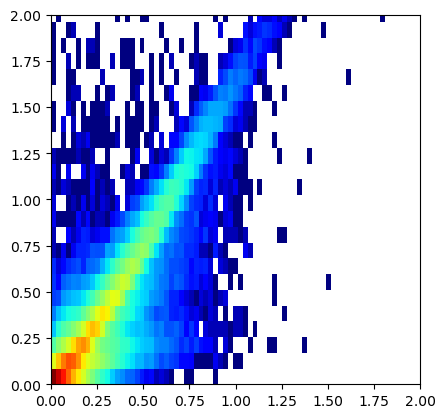

In [105]:
#print(dn1D)
a=np.nonzero(iwc_SSRG>0)
print(iwc_SSRG[a].mean())
print(iwc[a].mean())
print(np.corrcoef(iwc_SSRG[a],iwc[a]))
ax=plt.subplot(111)
iwc_hist2d=plt.hist2d(iwc_SSRG[a],iwc[a],bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.xlim(0,2)
plt.ylim(0,2)
ax.set_aspect('equal')